In [43]:
def get_time_dict():
    d = dict()
    for i in range(24):
        d[i] = 0
    return d

In [44]:
def find_nth_occurence(string, substring, occurence):
    last = -1
    for _ in range(occurence):
        try:
            last = string.find(substring, last + 1)
            if last == -1:
                return -1
        except:
            return None
    return last


def extract_components(msg, date_format, messenger):
    from dateutil import parser
    try:
        if messenger == "Hike":
            end = find_nth_occurence(msg, ":", 3)
            if end == -1:
                return (None,) * 3
            msg_start = msg.find("-", end+1)
            if msg_start == -1:
                return (None,) * 3
            sender = msg[end+1:msg_start]
            content = msg[msg_start+1:-1]
            if content == "":
                return (None,) * 3
            date_time = None
            if date_format == "dd/mm/yy":
                date_time = parser.parse(msg[:end], dayfirst = True)
            else:
                date_time = parser.parse(msg[:end])
            return date_time, sender, content
        elif messenger == "Whatsapp":
            end = msg.index("-")
            if end == -1:
                return (None,) * 3
            msg_start = msg.find(":", end+1)
            if msg_start == -1:
                return (None,) * 3
            sender = msg[end+1: msg_start]
            content = msg[msg_start+1:-1]
            if content == "":
                return (None,) * 3
            date_time = None
            if date_format == "dd/mm/yy":
                date_time = parser.parse(msg[:end].replace(",", ""), dayfirst = True)
            else:
                date_time = parser.parse(msg[:end].replace(",", ""))
            return date_time, sender, content
    except:
        return (None,) * 3


def convert_to_structured_format(chat, date_format, messenger):
    senders = set()      # To mark whether a message traversed is from a new sender or old
    messages = dict()    # Store all messages in structured format
    dates = dict()       # Store all dates in structures format
    time_stats = dict()
    time_stats_words = dict()
    last = None

    for msg in chat:
        date_time, sender, content = extract_components(msg, date_format, messenger)
        if date_time == None:
            if last != None:
                messages[last][-1] += msg   # Newline in previous msg, must be appended to last message
                continue
            else:
                continue    # Description at beginning of chat(not important)
        sender = sender.strip()
        content = content.strip()
        last = sender
        # Adding data
        if sender not in senders:
            senders.add(sender)
            messages[sender] = [content]
            dates[sender] = dict()
            time_stats[sender] = get_time_dict()
            time_stats_words[sender] = get_time_dict()
        else:
            messages[sender].append(content)
        
        date = date_time.date()
        if date in dates[sender]:
            dates[sender][date] += 1
        else:
            dates[sender][date] = 1
        time_stats[sender][date_time.hour] += 1
        time_stats_words[sender][date_time.hour] += content.count(" ") + 1
        last = sender
    return senders, messages, dates, time_stats, time_stats_words

In [45]:
def convert_date(date):
    # Convert date from dd/mm/yy format to day-mon-YY format
    res = str(date.day)
    if date.day in (1,21,31):
        res += 'st'
    elif date.day in (2,22):
        res += 'nd'
    elif date.day in (3,23):
        res += 'rd'
    else:
        res += 'th'
    months = ['', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    res += " " + months[int(date.month)]
    res += " " + str(date.year) 
    return res

def biggest_date_difference(dates):       # Input: list[key list of dates dictionary]
    dates.sort()
    if len(dates) == 1:
        return 0, dates[0], dates[0]
    max_diff = abs((dates[1] - dates[0]).days)
    date1 = dates[0]
    date2 = dates[1]
    for i in range(1, len(dates)):
        diff = abs((dates[i] - dates[i-1]).days)
        if diff > max_diff:
            max_diff = diff
            date1 = dates[i-1]
            date2 = dates[i]
    
    return max_diff, date1, date2

def longest_streak(dates):                # Input: list[key list of dates dictionary]
    dates.sort()
    streak = 1
    max_streak = 1
    st, max_st = dates[0], dates[0]
    en, max_en = dates[0], dates[0]
    for i in range(1,len(dates)):
        if abs((dates[i] - dates[i-1]).days) == 1:
            streak += 1
            en = dates[i]
        else:
            if streak > max_streak:
                max_streak = streak
                max_st = st
                max_en = en
            streak = 1
            st = dates[i]
    if streak > max_streak:
        max_streak = streak
        max_st = st
        max_en = en
    return max_streak, max_st, max_en

def most_messages_per_day(dates):              # Input: dictionary[dates dictionary]
    top3 = [[None, 0], [None, 0], [None, 0]]       # [0]: 3rd rank, [1]: 2nd rank [2]: 3rd rank
    for i in dates:
        if top3[0][1] < dates[i]:
            top3[0][0] = i
            top3[0][1] = dates[i]
        top3.sort(key = lambda x: x[1])
    return top3

def sender_count(sender_msg):
    return len(sender_msg)

def count_words(msg):
    if msg == '<Media Omitted>':
        return 0
    return msg.count(' ') + 1

In [46]:
from stat_functions import *

def run_statistics(senders, messages, dates, messenger):
    user_stats = dict()
    total_msgs = 0

    # General stats
    for sender in senders:
        user_stats[sender] = dict()
        
        date_diff, st, en = biggest_date_difference(list(dates[sender].keys()))
        user_stats[sender]['biggest_date_difference'] = (date_diff, convert_date(st), convert_date(en))
        
        streak, st, en = longest_streak(list(dates[sender].keys()))
        user_stats[sender]['longest_streak'] = (streak, convert_date(st), convert_date(en))
        
        top3 = most_messages_per_day(dates[sender])[::-1]
        end = len(top3)
        for i in range(len(top3)):
            if top3[i][0] == None:
                end = i
                break
            top3[i][0] = convert_date(top3[i][0])
        top3 = top3[:end]
        user_stats[sender]['most_messages'] = top3
        
        count = sender_count(messages[sender])
        user_stats[sender]['total_messages'] = count
        total_msgs += count

    # Analyzing message contents
    for sender in senders:
        count = 0
        user_stats[sender]['word_count'] = 0
        if messenger == 'Hike':
            user_stats[sender]['nudges'] = 0
            total_nudges = 0
        for m in messages[sender]:
            if "<Media omitted>" in m:
                count += 1
            if messenger == 'Hike' and m.strip() == 'Nudge!':
                user_stats[sender]['nudges'] += 1
                total_nudges += 1
            user_stats[sender]['word_count'] += count_words(m)
        user_stats[sender]["media"] = count

    # Overall Statistics
    participants = []
    for sender in senders:
        participants.append([sender, user_stats[sender]['total_messages']])
    participants.sort(key = lambda x: -x[1])

    date_count = dict()
    for sender in senders:
        for date in dates[sender]:
            if date in date_count:
                date_count[date] += dates[sender][date]
            else:
                date_count[date] = dates[sender][date]
    date_count = list(date_count.items())
    date_count.sort(key = lambda x: -x[1])

    overall_stats = dict()
    overall_stats['users'] = participants
    overall_stats['dates'] = date_count
    overall_stats['total_msgs'] = total_msgs
    if messenger == 'Hike':
        overall_stats['total_nudges'] = total_nudges   
    return user_stats, overall_stats

In [47]:
def print_stats(user_stats, overall_stats):
    print("OVERALL STATISTICS:-")
    print("Total Messages: ", overall_stats["total_msgs"])
    
    print("\n\nUSER STATISTICS:-")
    for sender in user_stats:
        print(sender.upper())
        for stat in user_stats[sender]:
            print(stat, ":", user_stats[sender][stat])

In [48]:
file_path = './uploads/wcd.txt'
date_format = 'dd/mm/yy'
messenger = 'Whatsapp'

chat = []
with open(file_path, mode = 'r', encoding = 'utf-8') as f:
    chat.extend(f.readlines())

senders, messages, dates, time_stats, time_stats_words = convert_to_structured_format(chat, date_format, messenger)
user_stats, overall_stats = run_statistics(senders, messages, dates, messenger)
# create_html_page(senders, user_stats, overall_stats, file_path, messenger)
print_stats(user_stats, overall_stats)

OVERALL STATISTICS:-
Total Messages:  8389


USER STATISTICS:-
DOBI
biggest_date_difference : (45, '18th August 2019', '2nd October 2019')
longest_streak : (12, '21st November 2018', '2nd December 2018')
most_messages : [['24th October 2019', 166], ['18th November 2019', 166], ['21st April 2020', 162]]
total_messages : 4591
word_count : 20914
media : 414
MRUDUL
biggest_date_difference : (45, '18th August 2019', '2nd October 2019')
longest_streak : (29, '3rd November 2019', '1st December 2019')
most_messages : [['24th October 2019', 135], ['21st April 2020', 117], ['18th November 2019', 113]]
total_messages : 3798
word_count : 25951
media : 352


In [49]:
def update_time_stats(time_stats):
    for sender in time_stats:
        for t in range(24):
            if t % 3:
                time_stats[sender][t - t % 3] += time_stats[sender][t]
                del time_stats[sender][t]
    for sender in time_stats:
        for ts in time_stats[sender]:
            if type(ts) == str:
                continue
            te = int(ts) + 3
            time_stats[sender][str(ts) + " - " + str(te)] = time_stats[sender][ts]
            del time_stats[sender][ts]
    return time_stats

time_stats = update_time_stats(time_stats)
time_stats_words = update_time_stats(time_stats_words)

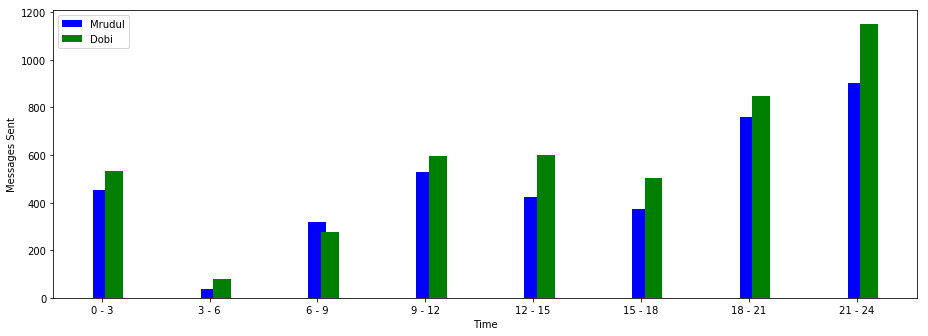

In [56]:
import matplotlib.pyplot as plt
fig = plt.figure()
plot = fig.add_subplot(111)
ax = fig.add_axes([0,0,2,1])
# time_val1 = list(time_stats['Mrudul'].keys())
time_val_temp1 = [(ts + 3/2.0) for ts in range(24) if ts % 3 == 0]
time_val_temp2 = [t + 0.35 for t in time_val_temp1]
# time_val2 = [t + 0.25 for t in time_val1]
time_count1 = [time_stats['Mrudul'][t] for t in time_val1]
ticks = time_val_temp1
graph = ax.bar(time_val_temp1,time_count1, color = 'b', width = 0.50, label = 'Mrudul')
time_count2 = [time_stats['Dobi'][t] for t in time_val1]
ax.bar(time_val_temp2,time_count2, color = 'g', width = 0.50, label = 'Dobi')
plt.xticks(ticks)
ax.set_xticklabels(list(time_stats['Mrudul'].keys()))
plt.xlabel("Time")
plt.ylabel("Messages Sent")
plt.legend()
plt.savefig("time_viz.png", bbox_inches = 'tight')
plt.show()

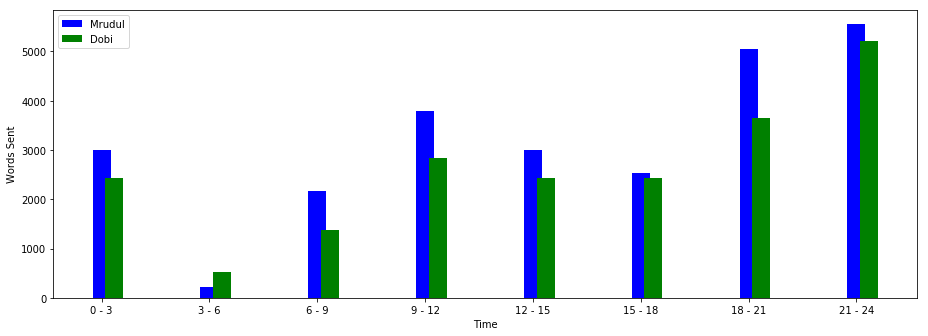

In [53]:
fig = plt.figure()
plot = fig.add_subplot(111)
ax = fig.add_axes([0,0,2,1])
time_val1 = list(time_stats_words['Mrudul'].keys())
time_val_temp1 = [(ts + 3/2.0) for ts in range(24) if ts % 3 == 0]
time_val_temp2 = [t + 0.35 for t in time_val_temp1]
# time_val2 = [t + 0.25 for t in time_val1]
time_count1 = [time_stats_words['Mrudul'][t] for t in time_val1]
ticks = time_val_temp1
graph = ax.bar(time_val_temp1,time_count1, color = 'b', width = 0.50, label = 'Mrudul')
time_count2 = [time_stats_words['Dobi'][t] for t in time_val1]
ax.bar(time_val_temp2,time_count2, color = 'g', width = 0.50, label = 'Dobi')
plt.xticks(ticks)
ax.set_xticklabels(list(time_stats_words['Mrudul'].keys()))
plt.xlabel("Time")
plt.ylabel("Words Sent")
plt.legend()
plt.savefig("time_viz.png")
plt.show()

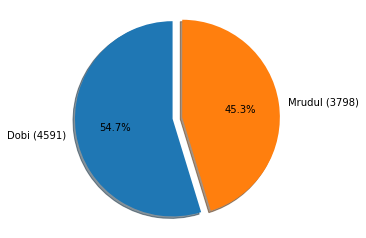

In [54]:
# Message Count Viz.
labels = []
sizes = []
for l, s in overall_stats['users']:
    sizes.append(s)
    labels.append(l + " (" + str(sizes[-1]) + ")")
explode = [0.0] * len(labels)
explode[sizes.index(max(sizes))] = 0.1
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode = explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

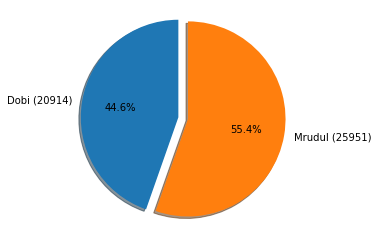

In [55]:
# Word Count Viz.
labels = []
sizes = []
for sender in user_stats:
    sizes.append(user_stats[sender]['word_count'])
    labels.append(sender + " (" + str(sizes[-1]) + ")")
explode = [0.0] * len(labels)
explode[sizes.index(max(sizes))] = 0.1
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode = explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()